In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## OMTF definitions and imports

In [1]:
import glob

import tensorflow as tf
import tensorflow_addons as tfa

import os
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy

import pandas as pd
import importlib

inputDataPrefix = ""

SLURM_CLUSTER_NAME=str(os.getenv("SLURM_CLUSTER_NAME"))
runOnCluster = False
if SLURM_CLUSTER_NAME == "prometheus":
    inputDataPrefix = "/net/people/plgakalinow/plggcmsml/"
    runOnCluster = True
elif SLURM_CLUSTER_NAME == "rysy":   
    inputDataPrefix = "/home/akalinow/"
    runOnCluster = True
else: 
    inputDataPrefix =  "/home/user1/scratch_ssd/akalinow/"
    runOnCluster = False
    
trainDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/"   
testDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/" 

nRefLayers = 8
nLayers = 18
nPDFBins = 2**7
minProbability = 0.001
minPlog = np.log(minProbability)
nPdfValBits = 6
refLayers = [0, 7, 2, 6, 16, 4, 10, 11]
ptBins = tf.concat([tf.range(0.0, 5, 0.5), tf.range(5, 30, 1.0), tf.range(30, 40, 5.0), tf.range(40, 60, 10.0), tf.range(60, 101, 20.0), [99999.0]], axis=0)

In [ ]:
tensor = tf.searchsorted(ptBins, [200.0], side='left')
print(tensor)
pt = tf.where(ptBins.numpy()[tensor]<9999, ptBins.numpy()[tensor], [200])
print(pt)
ptBins

## Use mixed precision policy: 32 bits for data, 16 bits for weights

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


## Start Tensorboard server

In [ ]:
if not runOnCluster:
    %load_ext tensorboard
    %tensorboard --logdir logs/fit --port=8008 --bind_all

## Data manipulation functions

In [3]:
columns = np.array(['muonPt', 'muonEta', 'muonPhi', 'muonCharge', 'omtfPt', 'omtfEta',
       'omtfPhi', 'omtfCharge', 'omtfScore', 'omtfQuality', 'omtfRefLayer',
       'omtfProcessor', 'omtfFiredLayers', 'phiDist_0', 'phiDist_1',
       'phiDist_2', 'phiDist_3', 'phiDist_4', 'phiDist_5', 'phiDist_6',
       'phiDist_7', 'phiDist_8', 'phiDist_9', 'phiDist_10', 'phiDist_11',
       'phiDist_12', 'phiDist_13', 'phiDist_14', 'phiDist_15', 'phiDist_16',
       'phiDist_17'])

def getFeaturesMask():
    featuresMask = np.full_like(columns, False, dtype=np.bool)
    for iLayer in range(0, 18): 
        featureLabel = "phiDist_{}".format(iLayer)
        featuresMask += (columns==featureLabel)
    #featuresMask += columns=="omtfFiredLayers"
    #featuresMask += columns=="omtfRefLayer"
    #featuresMask += columns=="omtfPt"
    #featuresMask = columns=="omtfQuality"
    return featuresMask

def getFeature(name, dataRow):
    columnIndex = np.where(columns == name)[0][0]  
    return dataRow[:,columnIndex]

def parse_tensor(tensor):
    return tf.io.parse_tensor(tensor, out_type=tf.float32)

def pT2Label(tensor):
    tensor = tf.searchsorted(ptBins, tensor, side='left')
    return tensor
    
def label2Pt(tensor):  
    return tf.where(ptBins.numpy()[tensor]<9999, ptBins.numpy()[tensor], [200])

def modifyFeatures(dataRow, batchSize, isTrain=False):
    columnsMask = getFeaturesMask()
    features = tf.boolean_mask(dataRow, columnsMask, axis=1) 
    dummyValue = 128
    
    features = tf.where(features<9999, features, dummyValue) 
    features.set_shape([batchSize,np.count_nonzero(columnsMask)])
    
    features = tf.one_hot(tf.cast(features+128, dtype=tf.int32), depth=256)
    
    columnIndex = np.where(columns == "muonCharge")[0][0]  
    chargeLabels = (dataRow[:,columnIndex]+1)/2 
    chargeLabels.set_shape([batchSize,])
    
    columnIndex = np.where(columns == "muonPt")[0][0]
    ptLabels = dataRow[:,columnIndex]
    ptLabels.set_shape([batchSize,])
    #trainWeight = 1.0
    trainWeight = 1.0 + tf.where(ptLabels<7.0, 3*(7-ptLabels), 0.0)
    #trainWeight = tf.math.exp(-ptLabels)
     
    if isTrain:
        ptLabels = pT2Label(ptLabels)
        return (features, (ptLabels, chargeLabels), trainWeight)
    else:
        columnIndex = np.where(columns == "omtfPt")[0][0]  
        omtfPt = dataRow[:,columnIndex]
        columnIndex = np.where(columns == "omtfQuality")[0][0]  
        omtfQuality = dataRow[:,columnIndex]
        omtfPt = tf.where(omtfQuality>=12, omtfPt, 0) 
        omtfPt.set_shape([batchSize,])
        
        columnIndex = np.where(columns == "omtfCharge")[0][0]  
        omtfCharge = dataRow[:,columnIndex]
        omtfCharge = (omtfCharge+1)/2 
        omtfCharge.set_shape([batchSize,])
        
        columnIndex = np.where(columns == "muonEta")[0][0]  
        etaLabels = dataRow[:,columnIndex]
        etaLabels.set_shape([batchSize,])
        
        return (features, (ptLabels, chargeLabels, etaLabels), omtfPt, omtfCharge)
    return dataRow
    
def loadDataset(fileNames, isTrain, nEpochs=1, batchSize=1):   
    raw_dataset = tf.data.TFRecordDataset(fileNames, compression_type="GZIP")
    dataset = raw_dataset.map(parse_tensor,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batchSize, drop_remainder=True)
    #Split data into [features, labels] and modify features
    dataset = dataset.map(lambda x: modifyFeatures(x, batchSize, isTrain),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #dataset = dataset.cache('/scratch/akalinow/data_cache/')
    return dataset

def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(1E-10)
    tf.print("Execution time:", time.perf_counter() - start_time)

## Utility functions

In [4]:
def finalModelAnswer(predictions, cumulativePosteriorCut):
    variance = tf.math.reduce_variance(predictions[0], axis=1)
    
    x = np.arange(0,predictions[0].shape[1])
    x = np.broadcast_to(x, predictions[0].shape)
    mean = np.average(a=x,weights=predictions[0], axis=1)
    mean2 = np.average(a=x*x,weights=predictions[0], axis=1)
    sigma = np.sqrt(mean2-mean**2) 
    
    pt = tf.cumsum(predictions[0], axis=1)>cumulativePosteriorCut
    pt = tf.argmax(pt, axis=1)
    probability = np.amax(predictions[0], axis=1)
    charge = tf.cast(predictions[1]>0.5, dtype=tf.float32)
    charge =  tf.reshape(charge, (-1))
    return label2Pt(pt), charge, probability, sigma

def fillPandasDataset(aBatch, df, cumulativePosteriorCut):    
    features = aBatch[0]
    labels = aBatch[1]
    omtfPredictions = aBatch[2:4]
    probability = model.predict(features, use_multiprocessing=True)
    value = finalModelAnswer(probability, cumulativePosteriorCut)
    batch_df = pd.DataFrame(data={"genPt":labels[0], "genCharge":labels[1], "genEta":labels[2],
                                    "OMTF_pt":omtfPredictions[0], 
                                    "OMTF_charge":omtfPredictions[1], 
                                    "NN_pt": value[0],
                                    "NN_charge":value[1],
                                    "NN_prob":value[2],
                                    "NN_sigma":value[3],
                                    })
    return df.append(batch_df, ignore_index=True)

## Data reading test

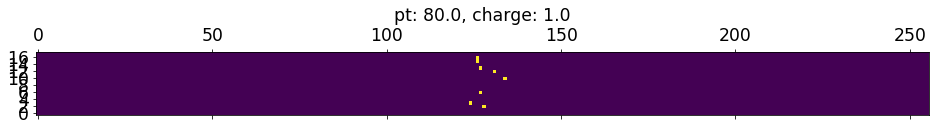

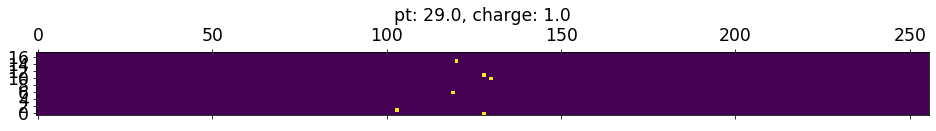

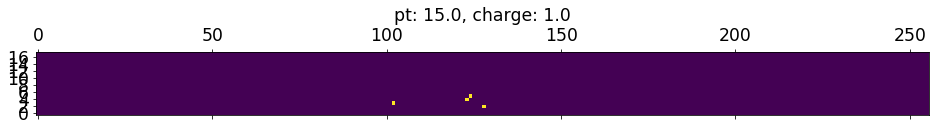

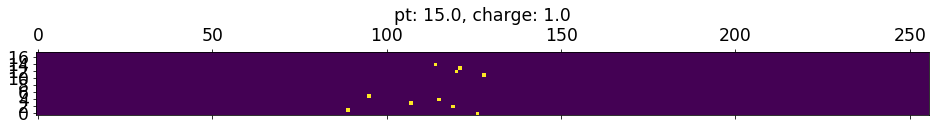

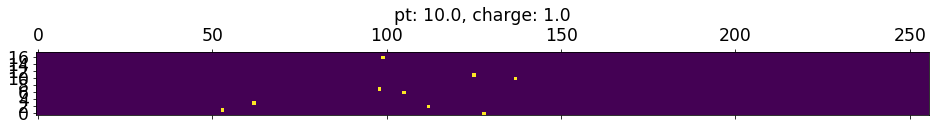

In [10]:
import plotting_functions as plf
importlib.reload(plf)

trainFileNames = glob.glob(trainDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')
trainFileNames = glob.glob(trainDataDir+'OMTFHits_pats0x0003_oldSample_files_*_chunk_0.tfrecord.gzip')
train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=1)
#benchmark(train_dataset)

#dataset = dataset.map(lambda x,y,z: tf.stack([x,y[1],y[1], z], axis=0))
#print(dataset)

#dataset = dataset.map(tf.io.serialize_tensor)

#mask = tf.constant([0,1,2,3,10,11,12,13], dtype=tf.int32)
#print(mask)

for element in train_dataset.take(5): 

  #trainn data format: (features, (ptLabels, chargeLabels), trainWeight)
  #print("Hits in iLayer 0:\n",element[0][0][0])
  #print("Hits in iLayer 1:\n",element[0][0][1])
  plf.plotEvent(element, label2Pt)

In [ ]:
testFileNames = glob.glob(trainDataDir+'df.parquet_OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.gzip')
#df = pd.read_parquet(testFileNames[0])
#print(df)
print(df["omtfFiredLayers"].min())

## Define models

In [5]:
def pull_mean_metric(y_true, y_pred):    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Pt(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Pt(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels   
    mean = tf.math.reduce_mean(pull, axis=0)
    return mean 
    
def pull_variance_metric(y_true, y_pred):
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Pt(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Pt(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels  
    variance = tf.math.reduce_variance(pull, axis=0) 
    return tf.sqrt(variance) 

def my_loss_fn(y_true, y_pred):
    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)
    predictions = tf.reshape(predictions, (-1,1))
    labels = y_true

    lowPtLoss = tf.math.logical_and(tf.math.less(labels, 10), tf.math.greater(predictions, 10))
    lowPtLoss = (predictions-labels)*lowPtLoss
    lowPtLoss = tf.cast(lowPtLoss, float32)
    
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred) + lowPtLoss


custom_objects={'pull_mean_metric': pull_mean_metric,
                'pull_variance_metric':pull_variance_metric,
                'my_loss_fn':my_loss_fn
               }

def getModel():
    
  nPtBins =  ptBins.shape[0]
  nInputs = np.sum(getFeaturesMask()) 
        
  inputs = tf.keras.Input(shape=(nInputs, 256), name="deltaPhi")
  #activation = tf.keras.activations.swish 
  activation = tf.keras.activations.relu 
  
  ptLayer = tf.keras.layers.Flatten(input_shape=inputs.shape[1:], name="Flatten_input_pt")(inputs) 
  #ptLayer = inputs
  for iLayer in range(0,5):
            ptLayer = tf.keras.layers.Dense(128, activation=activation, name="Pt_layer_{}".format(iLayer))(ptLayer)
    
  chargeLayer = tf.keras.layers.Flatten(input_shape=inputs.shape[1:], name="Flatten_input_charge")(inputs) 
  #chargeLayer= inputs
  for iLayer in range(0,1): 
       chargeLayer = tf.keras.layers.Dense(32, activation=activation, name="Charge_layer_{}".format(iLayer))(chargeLayer)
    
  ptOutput = tf.keras.layers.Dense(nPtBins, activation=tf.nn.softmax,bias_initializer='zeros',name = "pt")(ptLayer) 
  chargeOutput = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid,name = "charge")(chargeLayer)
        
  model = tf.keras.Model(inputs=inputs, outputs=[ptOutput, chargeOutput], name="NN")

  initial_learning_rate = 0.01
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.95,
    staircase=True)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss={"pt":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     "charge":tf.keras.losses.BinaryCrossentropy(from_logits=False)
                     },                    
                metrics=['accuracy'])
  tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
  return model


def loadModel(checkpoint_path):
    return tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)

getModel();

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [6]:
model = getModel()
model.summary()
print(ptBins.shape)

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deltaPhi (InputLayer)           [(None, 18, 256)]    0                                            
__________________________________________________________________________________________________
Flatten_input_pt (Flatten)      (None, 4608)         0           deltaPhi[0][0]                   
__________________________________________________________________________________________________
Pt_layer_0 (Dense)              (None, 128)          589952      Flatten_input_pt[0][0]           
__________________________________________________________________________________________________
Pt_layer_1 (Dense)              (None, 128)          16512       Pt_layer_0[0][0]                 
_______________________________________

## Train model

In [7]:
%%time

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

trainFileNames = glob.glob(trainDataDir+'OMTFHits_pats0x0003_oldSample_files_*_chunk_0.tfrecord.gzip')
validationFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')

train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=4*4096)
validation_dataset = loadDataset(validationFileNames, isTrain=True, nEpochs=1, batchSize=1024)

model = getModel()
model.summary()

#checkpoint_path = "training/0020_Oct_04_2021_17_25"
#model = tf.keras.models.load_model(checkpoint_path, custom_objects=custom_objects)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(10, 20))

nEpochs = 20
history = model.fit(train_dataset, epochs=nEpochs,
                            use_multiprocessing=True,
                            verbose=1,
                            shuffle=False,
                            validation_data=validation_dataset.take(10),
                            callbacks=[tensorboard_callback]
                           )

# Save the whole model
path = "training/{epoch:04d}_"+datetime.now().strftime("%b_%d_%Y_%H_%M")
model.save(path.format(epoch=nEpochs), save_format='tf')

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training end. Current Time =", current_time)

Training start. Current Time = Oct 07 2021 13:09:28
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deltaPhi (InputLayer)           [(None, 18, 256)]    0                                            
__________________________________________________________________________________________________
Flatten_input_pt (Flatten)      (None, 4608)         0           deltaPhi[0][0]                   
__________________________________________________________________________________________________
Pt_layer_0 (Dense)              (None, 128)          589952      Flatten_input_pt[0][0]           
__________________________________________________________________________________________________
Pt_layer_1 (Dense)              (None, 128)          16512       Pt_layer_0[0][0]     

INFO:tensorflow:Assets written to: training/0020_Oct_07_2021_14_41/assets


INFO:tensorflow:Assets written to: training/0020_Oct_07_2021_14_41/assets


Training end. Current Time = Oct 07 2021 14:41:54
CPU times: user 5h 23min 21s, sys: 2h 11min 42s, total: 7h 35min 3s
Wall time: 1h 32min 26s


## Model evaluation

The plots show the "posterior" probability that a given muons has $p_{T}$ in given bin. The correct behaviour is a peak round the true value, marked by a gren line.
Unfortunetly a small fraction of muons with very low true $p_{T}$, around a few GeV/c receive a vey large $p_{T}$ assigned by the NN: this is a big bump around 100 GeV/c.
This can be seen on the second plot: a efficency plot, where Y axis show fraction of muons with true $p_{T}$ marked by the X value, that get a NN or OMTF (human designed algorithm) greater or equal to 20 GeV/c. A small peak arount 3 GeV/c is visible. **Although this is small, it has very bad consequences, and has to be removed.**

Inference start. Current Time = Oct 08 2021 14:50:19
Pt gen = 11.2, Pt rec 0.7 cumulative posterior: [19.]


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


7.8541574
genPt           7.854157
genCharge       1.000000
genEta         -1.081651
OMTF_pt        18.000000
OMTF_charge     1.000000
NN_pt          21.000000
NN_charge       1.000000
NN_prob         0.082947
NN_sigma        6.232455
Name: 537, dtype: float64
Inference end. Current Time = Oct 08 2021 14:50:22


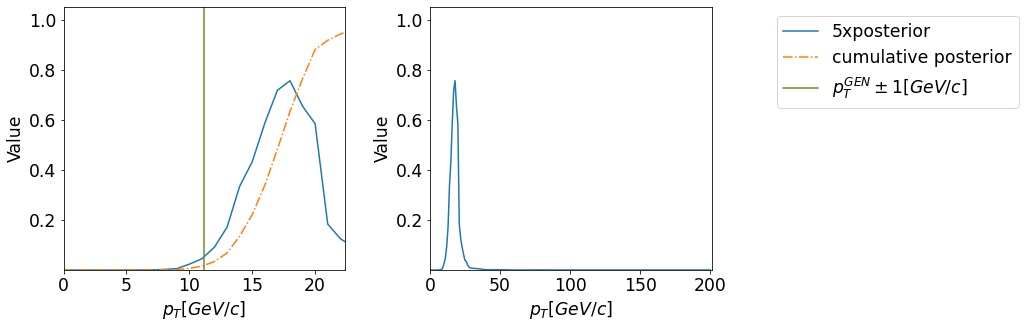

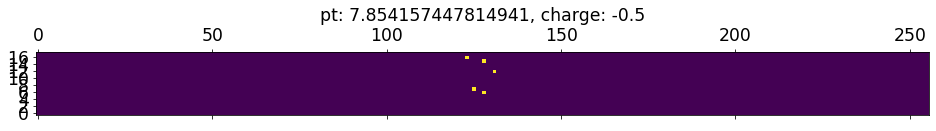

In [37]:
import plotting_functions as plf
importlib.reload(plf)

cumulativePosteriorCut = 0.80

if not runOnCluster:
    
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")   
    print("Inference start. Current Time =", current_time)
    
    #checkpoint_path = "training/0020_Oct_04_2021_17_25"
    #model = tf.keras.models.load_model(checkpoint_path, custom_objects=custom_objects)
    #model.summary()
    #print(ptBins.shape)

    testFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')    
    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=32*1024)
    
    df = pd.DataFrame(columns=["genPt", "genCharge", "genEta",
                                "OMTF_pt","OMTF_charge",
                                "NN_pt","NN_charge","NN_prob"])
    for aBatch in test_dataset.as_numpy_iterator():
        df = fillPandasDataset(aBatch, df, cumulativePosteriorCut)
        
        predictions = model.predict(aBatch[0], use_multiprocessing=True)
        
        ptGen=11.2
        labels=aBatch[1][0]
        plf.plotPosterior(ptGen=ptGen, labels=labels, predictions=predictions[0], label2Pt=label2Pt)
               
        x = (df["NN_pt"]>20)*(df["genPt"]<10)    
        #x = np.logical_and(labels>ptGen-0.1, labels<ptGen+0.1)
        index = np.argmax(x)
        print(aBatch[1][0][index])
        print(df.loc[index])
        image = aBatch[0][index]
        plt.matshow(image, origin = "lower")
        plt.title("pt: {}, charge: {}".format(aBatch[1][0][index],aBatch[1][1][index]/2-1))
        break
        
    
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
    print("Inference end. Current Time =", current_time)

'\nplf.plotTurnOn(df, ptCut=5)\nplf.plotTurnOn(df, ptCut=10)\nplf.plotTurnOn(df, ptCut=20)\nplf.plotTurnOn(df, ptCut=22)\nplf.plotTurnOn(df, ptCut=23)\nplf.plotTurnOn(df, ptCut=24)\nplf.plotTurnOn(df, ptCut=25)\nplf.plotTurnOn(df, ptCut=30)\nplf.plotTurnOn(df, ptCut=40)\nplf.plotTurnOn(df, ptCut=50)\nplf.plotTurnOn(df, ptCut=100)\nplf.plotTurnOn(df, ptCut=150)\nplf.plotTurnOn(df, ptCut=200)\nplf.plotPull(df)\nplf.plotCM(df, pT2Label)\nplf.plotRate(df)\n'

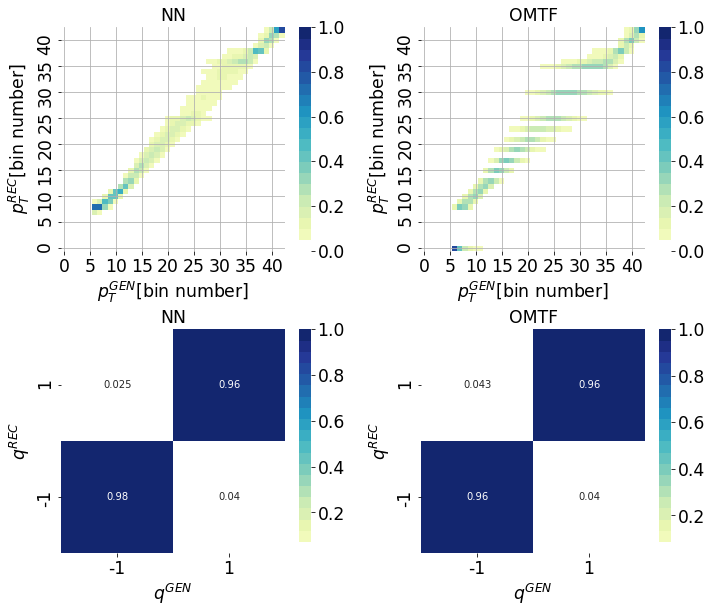

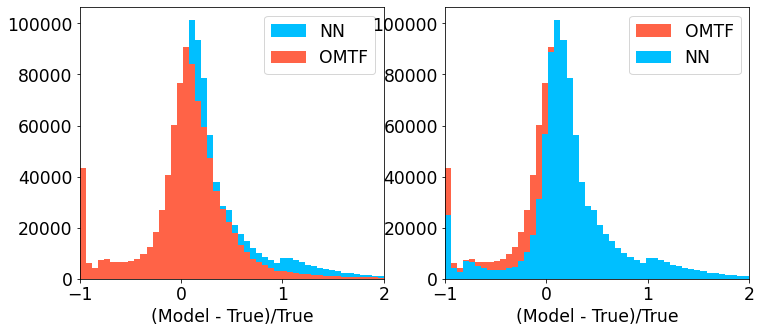

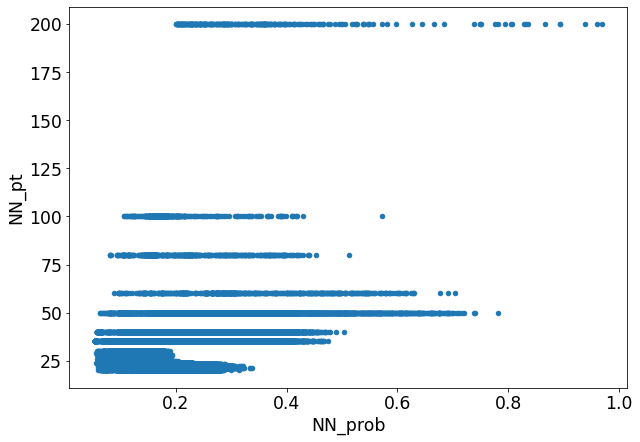

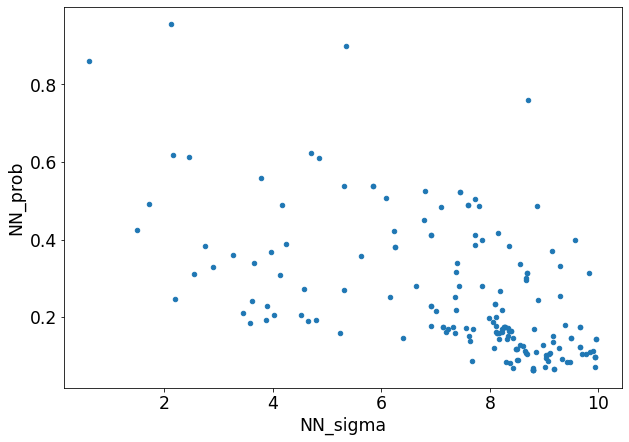

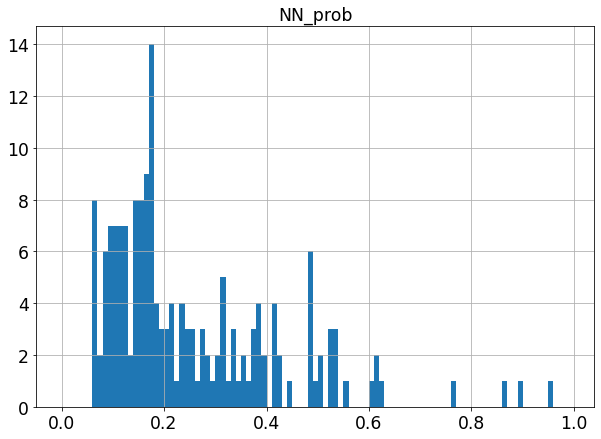

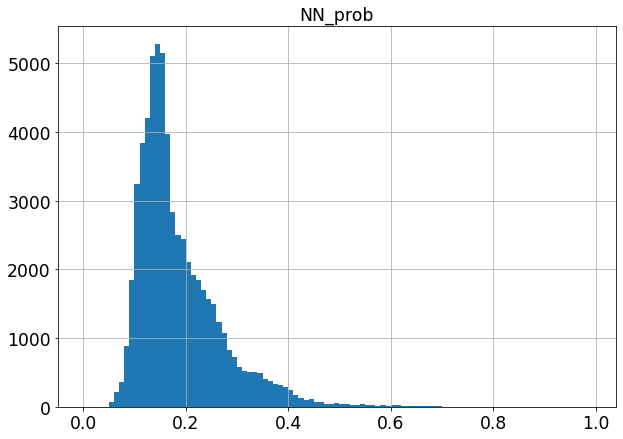

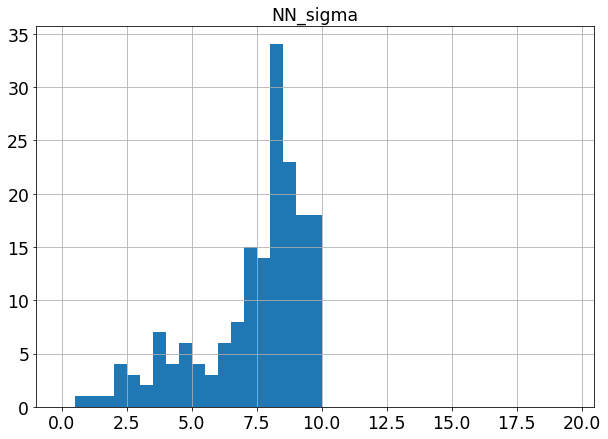

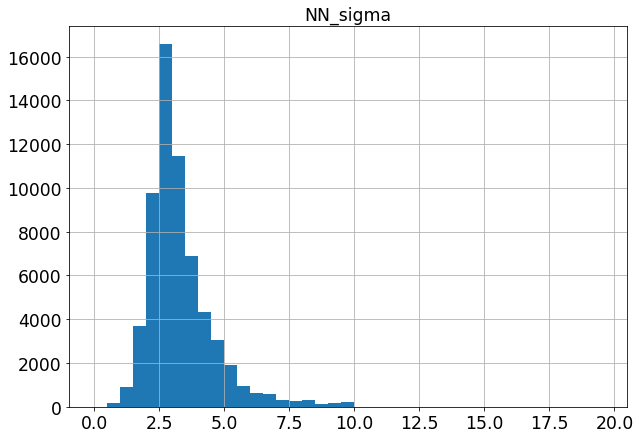

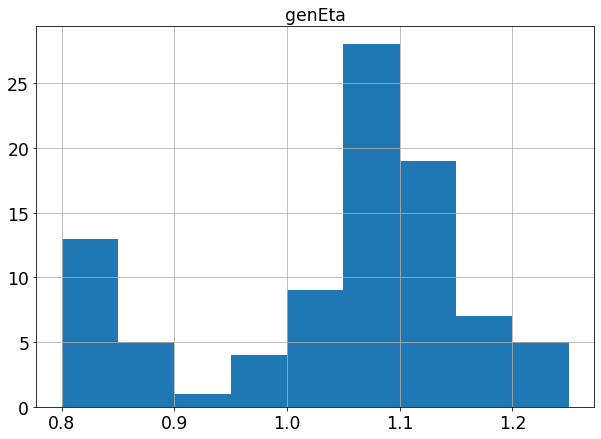

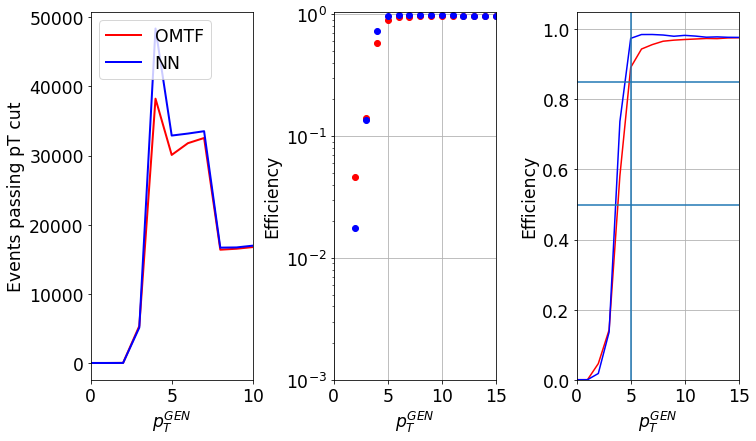

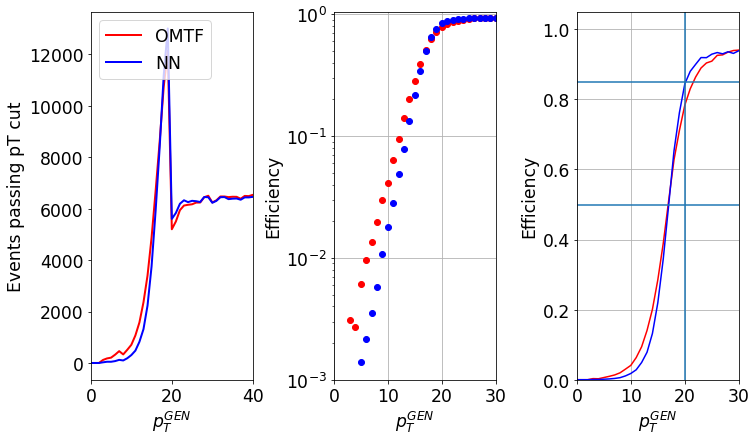

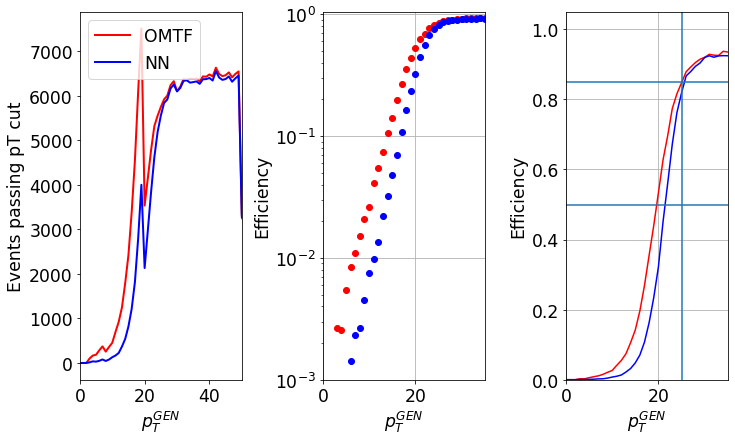

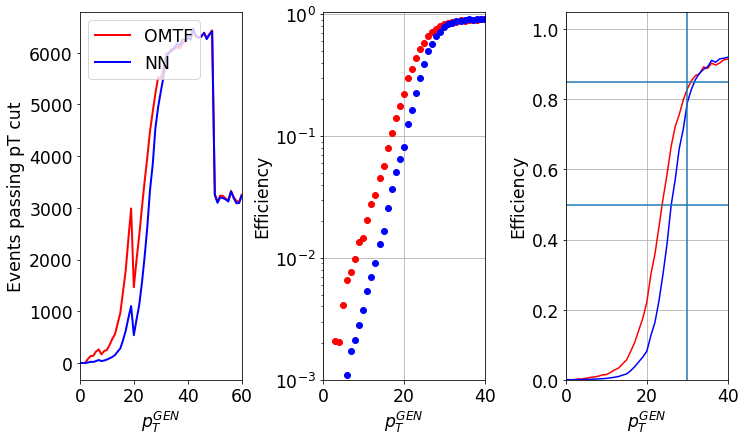

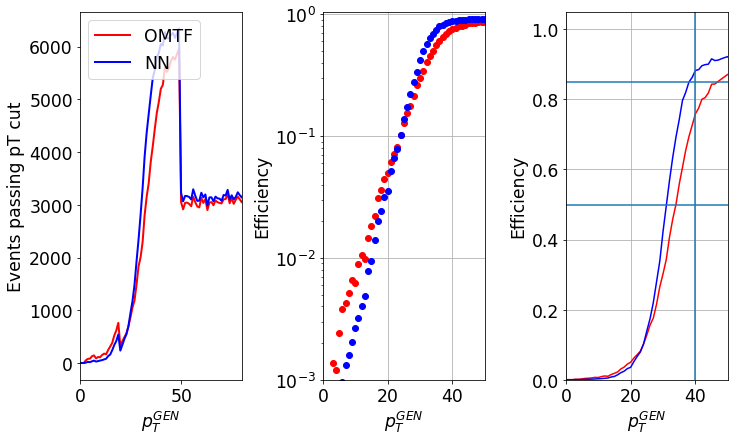

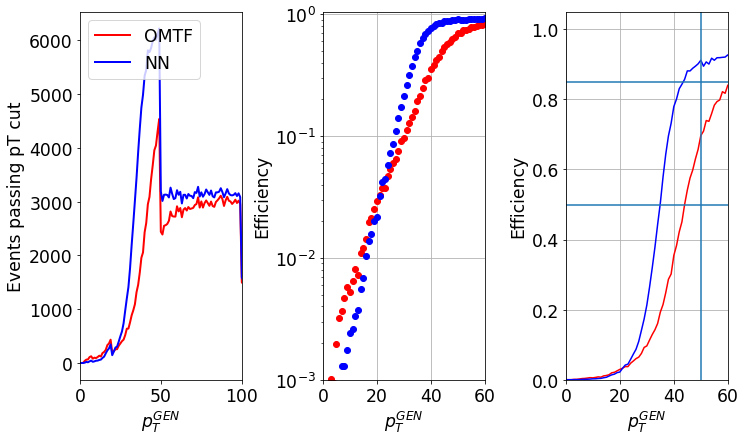

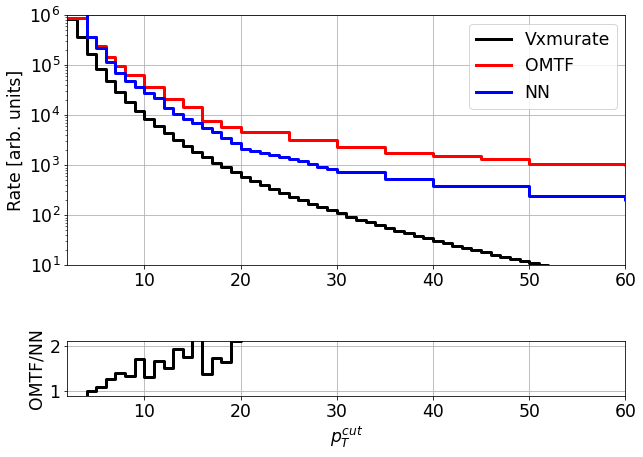

In [9]:
import plotting_functions as plf
importlib.reload(plf)

#df1 = df[np.abs(df["genEta"])>0.83]
#plf.plotTurnOn(df1, ptCut=20)
#plf.plotRate(df1)

df1 = df.copy()
df1["NN_pt"] = df["NN_pt"]*(df["NN_sigma"]<10)
                                                
dfFake = df1[(df1["genPt"]<10)&(df1["NN_pt"]>=50)]
dfTrue = df1[(df1["genPt"]>=20)&(df1["genPt"]<30)&(df1["NN_pt"]>=20)]
plf.plotCM(df1, pT2Label)
plf.plotPull(df1)
dfTrue.plot.scatter("NN_prob", "NN_pt")
dfFake.plot.scatter("NN_sigma", "NN_prob")
dfFake.hist("NN_prob", bins=np.arange(0,1.0,0.01))
dfTrue.hist("NN_prob", bins=np.arange(0,1.0,0.01))
dfFake.hist("NN_sigma", bins=np.arange(0,20,0.5))
dfTrue.hist("NN_sigma", bins=np.arange(0,20,0.5))
dfFake.hist("genEta", bins=np.arange(0.8,1.3,0.05))

plf.plotTurnOn(df1, ptCut=5)
plf.plotTurnOn(df1, ptCut=20)
plf.plotTurnOn(df1, ptCut=25)
plf.plotTurnOn(df1, ptCut=30)
plf.plotTurnOn(df1, ptCut=40)
plf.plotTurnOn(df1, ptCut=50)
plf.plotRate(df1)
'''
plf.plotTurnOn(df, ptCut=5)
plf.plotTurnOn(df, ptCut=10)
plf.plotTurnOn(df, ptCut=20)
plf.plotTurnOn(df, ptCut=22)
plf.plotTurnOn(df, ptCut=23)
plf.plotTurnOn(df, ptCut=24)
plf.plotTurnOn(df, ptCut=25)
plf.plotTurnOn(df, ptCut=30)
plf.plotTurnOn(df, ptCut=40)
plf.plotTurnOn(df, ptCut=50)
plf.plotTurnOn(df, ptCut=100)
plf.plotTurnOn(df, ptCut=150)
plf.plotTurnOn(df, ptCut=200)
plf.plotPull(df)
plf.plotCM(df, pT2Label)
plf.plotRate(df)
'''

In [ ]:
import plotting_functions as plf
importlib.reload(plf)

df1 = df[(df["genPt"]>10)&(df["genPt"]<20)]

plf.plotCM(df1, pT2Label)
plf.plotPull(df1)